## Imports

In [104]:
import pathlib, numpy as np, pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox 
import sys
from pathlib import Path
from scipy.stats import skew, kurtosis

# Add project root to sys.path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

from hybrid_ts.data import get_benchmark_prices

In [57]:
sp500, btc = get_benchmark_prices()

/Users/emmettralston/ml/HybridModel-TimeSeries-Forcasting/hybrid_ts/data.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(sp_path, index_col=0, parse_dates=True),
/Users/emmettralston/ml/HybridModel-TimeSeries-Forcasting/hybrid_ts/data.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(btc_path, index_col=0, parse_dates=True),


## BTC & SP500 Price and Log Returns Over Time


### Why we work with **log-returns** instead of simple % returns

* **Stationarity:**  
  Prices are random-walk–like (non-stationary). Taking the natural-log difference  
  (`log Pₜ − log Pₜ₋₁`) removes the unit-root drift, giving a series whose mean and variance are approximately constant—an essential assumption for ARIMA, Ljung-Box, and most ML models.

* **Additivity & scaling:**  
  Log-returns add across time: the 5-day log-return is simply the sum of five 1-day log-returns. This makes aggregation and compounding math cleaner than using simple returns.

* **Symmetry for gains and losses:**  
  A +10 % price move (+0.095 log-return) and a –10 % move (–0.105) are almost symmetric about zero, whereas simple returns are bounded below by –100 %.

* **Approximate normality:**  
  For daily data the Central Limit Theorem pulls log-returns closer to Gaussian than simple returns, improving the validity of statistical tests that assume normal residuals.

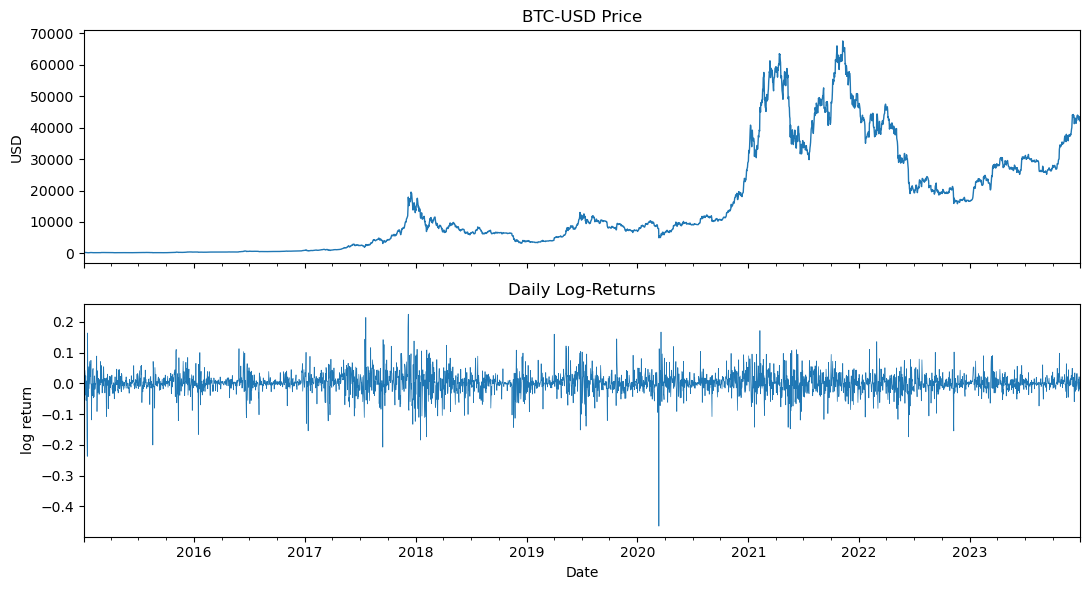

In [100]:
# Load CSV, skipping the first three metadata rows
df_btc = pd.read_csv("/Users/emmettralston/ml/HybridModel-TimeSeries-Forcasting/data/raw/btc.csv", skiprows=3, names=["Date", "Price"])

# Convert 'Date' column to datetime and set as index
df_btc["Date"] = pd.to_datetime(df_btc["Date"])
df_btc.set_index("Date", inplace=True)

# Extract price series
prices_btc = df_btc["Price"]

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

# 1a Price chart
prices_btc.plot(ax=ax[0], lw=1)
ax[0].set(title="BTC-USD Price", ylabel="USD")

# 1b Log-returns
logret_btc = np.log(prices_btc).diff().dropna()
logret_btc.plot(ax=ax[1], lw=0.5)
ax[1].set(title="Daily Log-Returns", ylabel="log return")

plt.tight_layout()
plt.show()


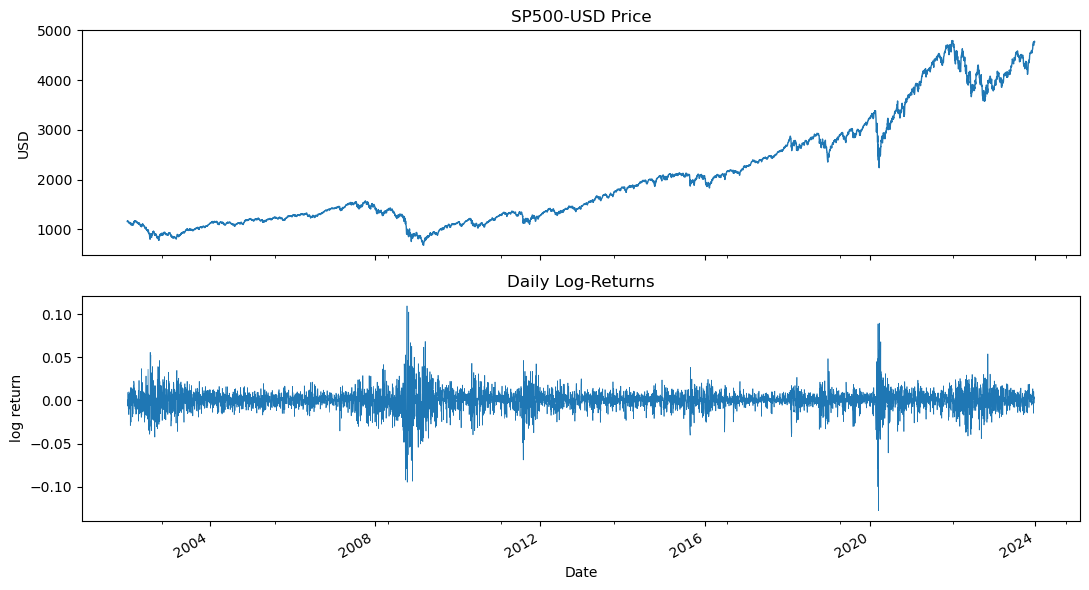

In [64]:
# Load CSV, skipping the first three metadata rows
df_sp = pd.read_csv("/Users/emmettralston/ml/HybridModel-TimeSeries-Forcasting/data/raw/sp500.csv", skiprows=3, names=["Date", "Price"])

# Convert 'Date' column to datetime and set as index
df_sp["Date"] = pd.to_datetime(df_sp["Date"])
df_sp.set_index("Date", inplace=True)

# Extract price series
prices_sp = df_sp["Price"]

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

# 1a Price chart
prices_sp.plot(ax=ax[0], lw=1)
ax[0].set(title="SP500-USD Price", ylabel="USD")

# 1b Log-returns
logret_sp = np.log(prices_sp).diff().dropna()
logret_sp.plot(ax=ax[1], lw=0.5)
ax[1].set(title="Daily Log-Returns", ylabel="log return")

plt.tight_layout()
plt.show()


## Stationarity checks: BTC and SP500

In [59]:
def adf(series):
    res = adfuller(series, autolag="AIC")
    return dict(stat=res[0], pval=res[1], lags=res[2], n=res[3])

def kpss_test(series):
    res = kpss(series, regression="c", nlags="auto")
    return dict(stat=res[0], pval=res[1], lags=res[2])

print("ADF  on price :", adf(prices_btc))
print("KPSS on price :", kpss_test(prices_btc))

print("ADF  on logret:", adf(logret_btc))
print("KPSS on logret:", kpss_test(logret_btc))

ADF  on price : {'stat': np.float64(-1.333725057627899), 'pval': np.float64(0.6136053507398368), 'lags': 29, 'n': 3256}
KPSS on price : {'stat': np.float64(5.668846454779685), 'pval': np.float64(0.01), 'lags': 37}
ADF  on logret: {'stat': np.float64(-58.55359406043843), 'pval': 0.0, 'lags': 0, 'n': 3284}
KPSS on logret: {'stat': np.float64(0.1483543869070741), 'pval': np.float64(0.1), 'lags': 13}


/var/folders/gy/jdbn2khj5hb_5z6zp6nwxjch0000gn/T/ipykernel_60646/3303050878.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(series, regression="c", nlags="auto")
/var/folders/gy/jdbn2khj5hb_5z6zp6nwxjch0000gn/T/ipykernel_60646/3303050878.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(series, regression="c", nlags="auto")


In [55]:
def adf(series):
    res = adfuller(series, autolag="AIC")
    return dict(stat=res[0], pval=res[1], lags=res[2], n=res[3])

def kpss_test(series):
    res = kpss(series, regression="c", nlags="auto")
    return dict(stat=res[0], pval=res[1], lags=res[2])

print("ADF  on price :", adf(prices_sp))
print("KPSS on price :", kpss_test(prices_sp))

print("ADF  on logret:", adf(logret_sp))
print("KPSS on logret:", kpss_test(logret_sp))

ADF  on price : {'stat': np.float64(1.305191646955431), 'pval': np.float64(0.9966378466995555), 'lags': 32, 'n': 5504}
KPSS on price : {'stat': np.float64(10.43178058665683), 'pval': np.float64(0.01), 'lags': 44}
ADF  on logret: {'stat': np.float64(-18.553729221168883), 'pval': np.float64(2.0910571170563417e-30), 'lags': 15, 'n': 5520}
KPSS on logret: {'stat': np.float64(0.180642848744816), 'pval': np.float64(0.1), 'lags': 25}


/var/folders/gy/jdbn2khj5hb_5z6zp6nwxjch0000gn/T/ipykernel_60646/403987238.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(series, regression="c", nlags="auto")
/var/folders/gy/jdbn2khj5hb_5z6zp6nwxjch0000gn/T/ipykernel_60646/403987238.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(series, regression="c", nlags="auto")




| Asset · Series | Augmented-Dickey–Fuller  (H₀ : unit root) | KPSS  (H₀ : level-stationary) | Verdict |
|----------------|-------------------------------------------|------------------------------|---------|
| **BTC price**        | **stat = −1.33** p = 0.61 → *fail to reject H₀* | **stat = 5.67** p < 0.01 → *reject H₀* | **Non-stationary** |
| **BTC log-returns**  | **stat ≈ −58.6** p ≈ 0 → *reject H₀* | **stat = 0.14** p > 0.10 → *fail to reject H₀* | **Stationary** |
| **S&P 500 price**    | **stat = +1.31** p ≈ 0.997 → *fail to reject H₀* | **stat = 10.43** p < 0.01 → *reject H₀* | **Non-stationary** |
| **S&P 500 log-returns** | **stat ≈ −18.6** p ≈ 0 → *reject H₀* | **stat = 0.18** p > 0.10 → *fail to reject H₀* | **Stationary** |

### Why this pattern is expected
 * **Augmented Dickey–Fuller (ADF) test:** checks whether a series has a **unit root** (i.e., is non-stationary); a low p-value lets us reject the unit-root hypothesis and treat the series as stationary.

* **KPSS test:** tests the opposite—whether a series is **level-stationary** around a constant mean; a low p-value makes us reject stationarity, signalling that some transformation is needed.

* A raw **price series** for any traded asset is typically a *random walk with drift*: shocks accumulate, making mean and variance time-dependent.  
  *Here, in both Bitcoin and the S&P 500, ADF cannot reject a unit root while KPSS firmly rejects stationarity.*

* **One-period log-returns** (`log Pₜ − log Pₜ₋₁`) remove the random-walk component and linearise percentage changes, producing a series that fluctuates around a stable mean with roughly constant variance.  
  *Both assets now show the opposite result: ADF strongly rejects a unit root and KPSS finds no evidence against stationarity, so each return series behaves like an I(0) (stationary) process.*

### Modelling implications

1. **Work with log-returns** rather than raw prices for both Bitcoin and the S&P 500.  
2. **No differencing (`d = 0`) is required** when fitting ARIMA or fractional-d ARIMA models to returns.  
3. Any hybrid machine-learning layers will inherit input series that already satisfy the stationarity assumption.


## ACF/PACF

### Context
* **ACF (Autocorrelation Function):** plots the correlation between a series and its own lags; we use it to spot repeating patterns and decide how many **MA(q)** terms a model might need (gradual decay → MA, sharp cutoff → AR).

* **PACF (Partial Autocorrelation Function):** shows the correlation at each lag **after** removing the influence of all shorter lags; a sharp spike at lag *p* followed by near-zero values suggests an **AR(p)** order for the model.

* **Ljung–Box test:** a cumulative χ² test on the first *m* autocorrelations; a low p-value signals that at least one of those lags is significantly different from zero, indicating leftover structure the model should capture.


In [103]:
# Descriptive statisitcs for log -returns
def describe(series: pd.Series) -> pd.Series:
    q = series.quantile
    return pd.Series({
        "Count":              series.size,
        "Min":                series.min() * 100,
        "1st quartile":       q(0.25) * 100,
        "Median":             q(0.50) * 100,
        "Arithmetic mean":    series.mean() * 100,
        "3rd quartile":       q(0.75) * 100,
        "Max":                series.max() * 100,
        "Standard deviation": series.std(ddof=0) * 100,
        "Skewness":           skew(series, bias=False),
        "Kurtosis":           kurtosis(series, bias=False, fisher=False)
    })
# Assemble the table
stats_df = pd.concat(
    {"S&P 500": describe(logret_sp), "Bitcoin": describe(logret_btc)},
    axis=1
).round(2)  # two-decimal formatting for readability

display(stats_df.style.format("{:,.2f}").set_caption("Descriptive statistics (% returns per day)"))

,S&P 500,Bitcoin
Count,"5,536.00","3,285.00"
Min,-12.77,-46.47
1st quartile,-0.45,-1.22
Median,0.07,0.14
Arithmetic mean,0.03,0.15
3rd quartile,0.58,1.69
Max,10.96,22.51
Standard deviation,1.22,3.74
Skewness,-0.42,-0.79
Kurtosis,14.50,14.62


### Histogram + Ljung-Box Summary — Bitcoin

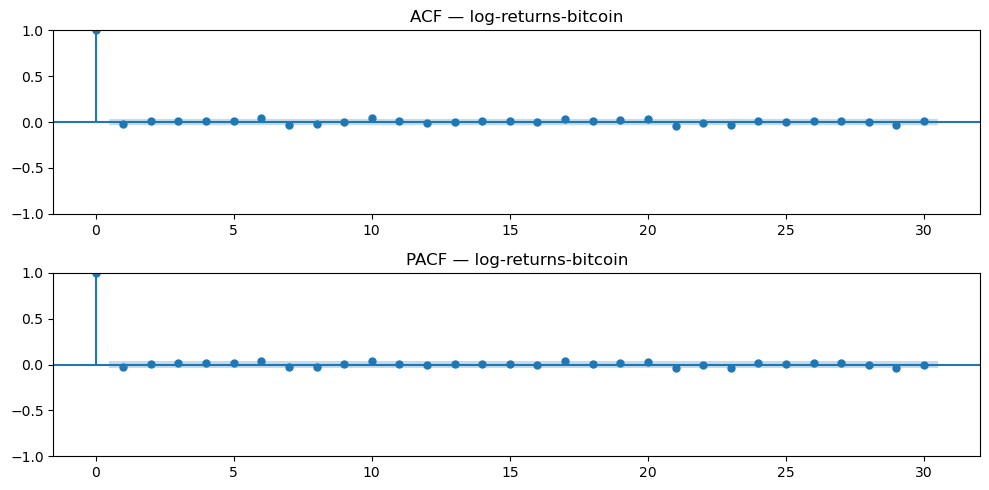

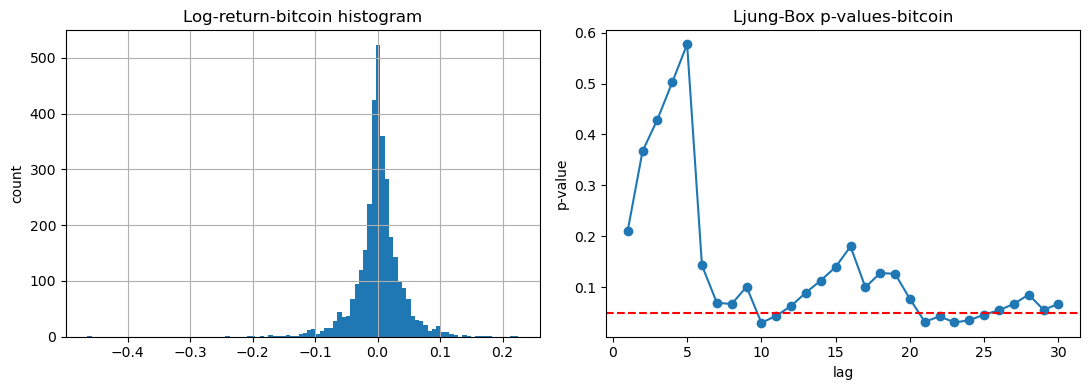

In [98]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
plot_acf(logret_btc, lags=30, ax=ax[0])
plot_pacf(logret_btc, lags=30, ax=ax[1], method="ywm")
ax[0].set(title="ACF — log-returns-bitcoin")
ax[1].set(title="PACF — log-returns-bitcoin")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# 4a histogram
logret_btc.hist(bins=100, ax=ax[0])
ax[0].set(title="Log-return-bitcoin histogram", ylabel="count")

# 4b Ljung-Box Q-stat up to 20 lags
lb_btc = acorr_ljungbox(logret_btc, lags=30, return_df=True)
ax[1].plot(lb_btc.index, lb_btc["lb_pvalue"], marker="o")
ax[1].axhline(0.05, color="red", ls="--")
ax[1].set(title="Ljung-Box p-values-bitcoin", xlabel="lag", ylabel="p-value")
plt.tight_layout(); plt.show()




| Diagnostic | What we saw | Interpretation |
|------------|-------------|----------------|
| **Histogram of daily log-returns** | Symmetric, roughly Gaussian **but with excess kurtosis ≈ 11.6**. | Heavy tails are common in crypto; large moves are more likely than under a Normal distribution. |
| **Ljung-Box p-values** | • p > 0.05 through lags 1–9 → no short-horizon autocorrelation.<br>• p < 0.05 at **lags 10 & 11** and again at **21 – 27**.<br>• Because \(Q_m\) is cumulative, p remains < 0.05 for every lag ≥ 32. | Small but significant pockets of dependence roughly every 10 days (and harmonics around 3 × 7 days). |

**Take-aways**

* Mean returns are *almost* white noise; an **ARMA(1,1)** or SARIMA with weak 7-day seasonality is likely sufficient.  


### Histogram + Ljung-Box Summary — S&P 500

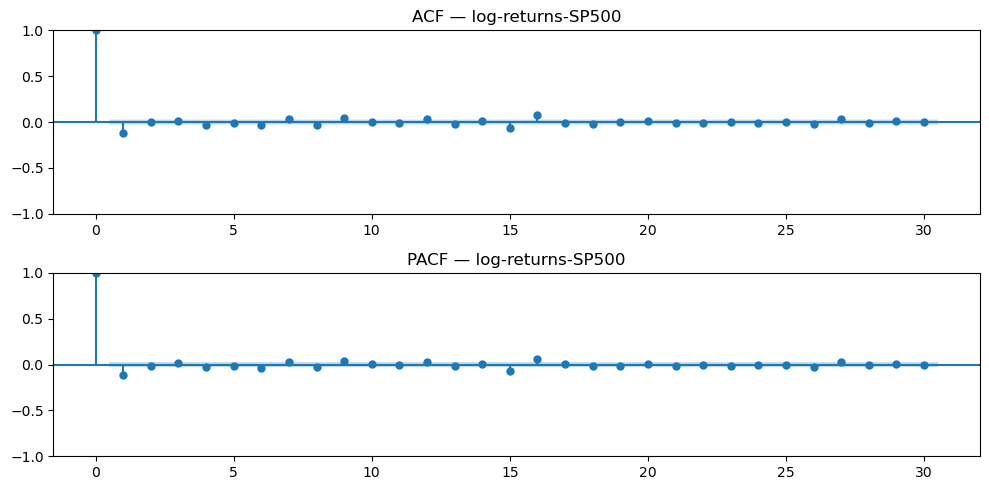

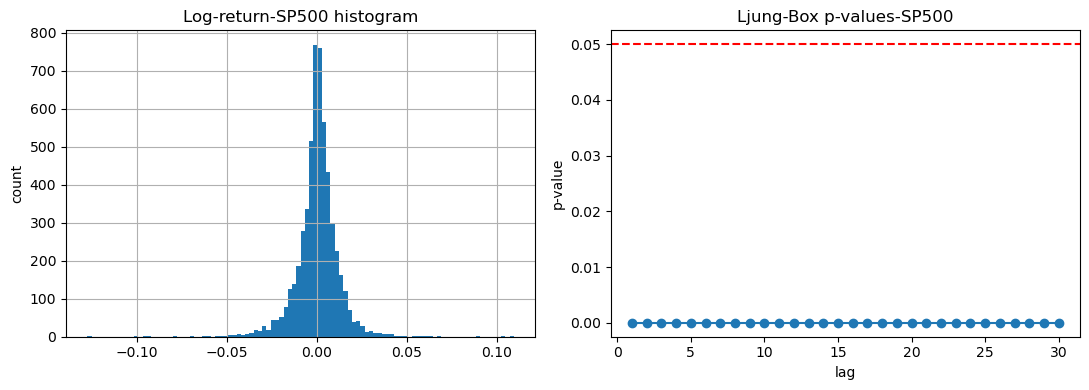

In [99]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
plot_acf(logret_sp, lags=30, ax=ax[0])
plot_pacf(logret_sp, lags=30, ax=ax[1], method="ywm")
ax[0].set(title="ACF — log-returns-SP500")
ax[1].set(title="PACF — log-returns-SP500")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# 4a histogram
logret_sp.hist(bins=100, ax=ax[0])
ax[0].set(title="Log-return-SP500 histogram", ylabel="count")

# 4b Ljung-Box Q-stat up to 20 lags
lb_sp = acorr_ljungbox(logret_sp, lags=30, return_df=True)
ax[1].plot(lb_sp.index, lb_sp["lb_pvalue"], marker="o")
ax[1].axhline(0.05, color="red", ls="--")
ax[1].set(title="Ljung-Box p-values-SP500", xlabel="lag", ylabel="p-value")
plt.tight_layout(); plt.show()




| Diagnostic | What we saw | Interpretation |
|------------|-------------|----------------|
| **Histogram of daily log-returns** | Symmetric, close to Normal with **excess kurtosis ≈ 11.5**. | Daily equity returns are often modelled as near-Gaussian with heavy tails. |
| **Ljung-Box p-values** | • p ≪ 0.05 starting at **lag 1** (autocorr ≈ –0.10) and therefore remain tiny for all larger lags. | The single, significant lag-1 autocorrelation drives the entire rejection; later lags add little new information. |

**Take-aways**

* An **AR(1)** (or MA(1)) with coefficient around –0.10 removes the micro-structure bounce; higher ARMA orders offer no tangible gain.  
* After that adjustment, residual mean returns are effectively white noise—predictability must come non-linear ML layers.
